<a href="https://colab.research.google.com/github/FranklineMisango/Deep_Learning_Projects/blob/main/Brain_Tumor_Prediction_3_0_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Importing the necessary libraries
#This version uses Lee Net Model Architecture
#The most accurate model
import pandas as pd
import numpy as np
import os
import random
import warnings
import matplotlib.pyplot as plt 
import math
import shutil
import glob
import cv2
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAvgPool2D
from keras.models import Sequential , Model , load_model
from keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import normalize
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.utils import to_categorical
%matplotlib inline


warnings.filterwarnings('ignore')

In [4]:
#Our Brain tumor dataset from Kaggle --> https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?resource=download
#Dowload the archive and load to collab and ran an extraction code to unzip the files
#I modified the dataset to only include the healthy & Brain tumor datasets to proceed with training & testing
#Incase of wrong folder uploads use : shutil.rmtree('/content/BrH35-Mask-Modified', ignore_errors=True)
from google.colab import files

#This snippet allows the user to only extract Archives to collab's directory
uploaded = files.upload()
filename =  list(uploaded.keys())[0]
if filename.endswith('zip'):
  os.system('unzip {}'.format(filename))
elif filename.endswith('tar.gz'):
  os.system('tar -xzvf {}'.format(filename))
else:
  print("Unsupported file format")

Saving Br35H_Brain_Tumor_Dataset_Archive.zip to Br35H_Brain_Tumor_Dataset_Archive (1).zip


In [5]:
#Counting the number of images that we have in classes ; [Brain Tumor] & [No Brain Tumor]
#We have both 1500 for Healthy Brain and 1500 for unhealthy dataset
ROOT_DIR = "/content/BrH35_Modified"
number_of_images = {}

#This code lists the Amounts of Healthy and Non-healthy Brain Tumor Datasets
for dir in os.listdir(ROOT_DIR):
  number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR,dir)))

number_of_images.items()


dict_items([('Healthy', 1500), ('Brain_Tumor', 1500)])

In [6]:
#Function to split the Test, Train and validation Datasets
#Train - 70%, Test - 15% and Validation - 15%
def DataFolderCreator(path,split):
  #Creating a Folder
  if not os.path.exists("./" + path):
    os.mkdir("./" + path)

    for dir in os.listdir(ROOT_DIR):
      os.makedirs("./" + path + "/" + dir)
      for image in np.random.choice(a = os.listdir(os.path.join(ROOT_DIR , dir)),
                                    size = (math.floor(split * number_of_images[dir]) - 5),
                                    replace = False):
        Original = os.path.join(ROOT_DIR, dir , image)
        Destination = os.path.join("./" + path , dir)
        shutil.copy(Original, Destination)
        os.remove(Original)
  else:
    print(f"{path} Folder Already Exists")

DataFolderCreator("Train", 0.7) 
DataFolderCreator("Test", 0.15)
DataFolderCreator("Validation", 0.15)

In [7]:
#Preparing our Data Generator and loading the saved images
#Data Augmentation
#1-Training Data
def preprocessingImagesTraining(path):
  #Input should be a path and output should be preprocessed images
  Image_data = ImageDataGenerator (zoom_range = 0.2 , shear_range = 0.2 ,preprocessing_function = preprocess_input, horizontal_flip = True)
  image = Image_data.flow_from_directory(directory = path , target_size  = (224,224), batch_size = 32 , class_mode = 'binary')

  return image

In [8]:
path = '/content/Train'
Train_data = preprocessingImagesTraining(path)
Train_data.class_indices

Found 2090 images belonging to 2 classes.


{'Brain_Tumor': 0, 'Healthy': 1}

In [9]:
#Testing the data; Blueprint from the training data one 
def preprocessingImagesTesting(path):
  #Input should be a path and output should be preprocessed images
  Image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
  image = Image_data.flow_from_directory(directory = path , target_size  = (224,224), batch_size = 32 , class_mode = 'binary')

  return image

In [10]:
#Testing the data
path = '/content/Test'
Test_data = preprocessingImagesTesting(path)

Found 440 images belonging to 2 classes.


In [11]:
#Validating the Images ; blueprint from testing the data one
def preprocessingImagesValidating(path):
  #Input should be a path and output should be preprocessed images
  Image_data = ImageDataGenerator(preprocessing_function = preprocess_input)
  image = Image_data.flow_from_directory(directory = path , target_size  = (224,224), batch_size = 32 , class_mode='binary')

  return image

In [12]:
#Validating the data
path = '/content/Validation'
Validation_data_preprocessing = preprocessingImagesValidating(path)

Found 440 images belonging to 2 classes.


In [13]:
#Model Training
base_model = MobileNet(input_shape=(224,224,3), include_top = False)

17225924/17225924 [==============================] - 0s 0us/step


In [14]:
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [15]:
for layer in base_model.layers:
  layer.trainable = False

In [16]:
X = Flatten()(base_model.output)
X = Dense(units = 1 , activation = 'sigmoid')(X)
model = Model(base_model.input, X)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [17]:
model.compile(optimizer='rmsprop', loss = keras.losses.binary_crossentropy ,metrics = ['accuracy'])

In [21]:
#Call back and early stopping

mc = ModelCheckpoint(filepath = 'bestmodel.h5', monitor='val_accuracy', verbose = 1, save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', min_delta = 0.01, patience = 3, verbose = 1 )
cb  = [mc,es]

In [23]:
hist = model.fit_generator(Train_data,
                           steps_per_epoch=10,
                           epochs = 30,
                           validation_data = Validation_data_preprocessing,
                           validation_steps = 16,
                           callbacks = cb)

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 6.1818 - accuracy: 0.6376


Epoch 1: val_accuracy improved from -inf to 0.90682, saving model to bestmodel.h5
10/10 [==============================] - 41s 4s/step - loss: 6.1818 - accuracy: 0.6376 - val_loss: 0.5479 - val_accuracy: 0.9068
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 1.0689 - accuracy: 0.8375

10/10 [==============================] - 18s 2s/step - loss: 1.0689 - accuracy: 0.8375
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.3633 - accuracy: 0.9344

10/10 [==============================] - 18s 2s/step - loss: 0.3633 - accuracy: 0.9344
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 1.7104 - accuracy: 0.8289

10/10 [==============================] - 17s 2s/step - loss: 1.7104 - accuracy: 0.8289
Epoch 5/30
10/10 [==============================] - ETA: 0s - loss: 1.1957 - accuracy: 0.8531

10/10 [==============================] - 19s 2s/step - loss: 1.1957 - accuracy: 0.8531
Epoch 6/30
10/10 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.9438

10/10 [==============================] - 18s 2s/step - loss: 0.3936 - accuracy: 0.9438
Epoch 7/30
10/10 [==============================] - ETA: 0s - loss: 1.0108 - accuracy: 0.8750

10/10 [==============================] - 19s 2s/step - loss: 1.0108 - accuracy: 0.8750
Epoch 8/30
10/10 [==============================] - ETA: 0s - loss: 0.7912 - accuracy: 0.8687

10/10 [==============================] - 18s 2s/step - loss: 0.7912 - accuracy: 0.8687
Epoch 9/30
10/10 [==============================] - ETA: 0s - loss: 0.4591 - accuracy: 0.9187

10/10 [==============================] - 20s 2s/step - loss: 0.4591 - accuracy: 0.9187
Epoch 10/30
10/10 [==============================] - ETA: 0s - loss: 0.1108 - accuracy: 0.9832

10/10 [==============================] - 17s 2s/step - loss: 0.1108 - accuracy: 0.9832
Epoch 11/30
10/10 [==============================] - ETA: 0s - loss: 1.2562 - accuracy: 0.8993

10/10 [==============================] - 18s 2s/step - loss: 1.2562 - accuracy: 0.8993
Epoch 12/30
10/10 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9688

10/10 [==============================] - 18s 2s/step - loss: 0.1226 - accuracy: 0.9688
Epoch 13/30
10/10 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9750

10/10 [==============================] - 18s 2s/step - loss: 0.1446 - accuracy: 0.9750
Epoch 14/30
10/10 [==============================] - ETA: 0s - loss: 1.0313 - accuracy: 0.8656

10/10 [==============================] - 18s 2s/step - loss: 1.0313 - accuracy: 0.8656
Epoch 15/30
10/10 [==============================] - ETA: 0s - loss: 0.1892 - accuracy: 0.9844

10/10 [==============================] - 18s 2s/step - loss: 0.1892 - accuracy: 0.9844
Epoch 16/30
10/10 [==============================] - ETA: 0s - loss: 0.0440 - accuracy: 0.9719

10/10 [==============================] - 18s 2s/step - loss: 0.0440 - accuracy: 0.9719
Epoch 17/30
10/10 [==============================] - ETA: 0s - loss: 1.1465 - accuracy: 0.8969

10/10 [==============================] - 19s 2s/step - loss: 1.1465 - accuracy: 0.8969
Epoch 18/30
10/10 [==============================] - ETA: 0s - loss: 0.4074 - accuracy: 0.9563

10/10 [==============================] - 18s 2s/step - loss: 0.4074 - accuracy: 0.9563
Epoch 19/30
10/10 [==============================] - ETA: 0s - loss: 0.1258 - accuracy: 0.9781

10/10 [==============================] - 18s 2s/step - loss: 0.1258 - accuracy: 0.9781
Epoch 20/30
10/10 [==============================] - ETA: 0s - loss: 1.7836 - accuracy: 0.8875

10/10 [==============================] - 20s 2s/step - loss: 1.7836 - accuracy: 0.8875
Epoch 21/30
10/10 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9937

10/10 [==============================] - 18s 2s/step - loss: 0.0353 - accuracy: 0.9937
Epoch 22/30
10/10 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9937

10/10 [==============================] - 19s 2s/step - loss: 0.0092 - accuracy: 0.9937
Epoch 23/30
10/10 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.9531

10/10 [==============================] - 19s 2s/step - loss: 0.3255 - accuracy: 0.9531
Epoch 24/30
10/10 [==============================] - ETA: 0s - loss: 0.5868 - accuracy: 0.9438

10/10 [==============================] - 26s 3s/step - loss: 0.5868 - accuracy: 0.9438
Epoch 25/30
10/10 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9781

10/10 [==============================] - 19s 2s/step - loss: 0.0807 - accuracy: 0.9781
Epoch 26/30
10/10 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9781

10/10 [==============================] - 19s 2s/step - loss: 0.0563 - accuracy: 0.9781
Epoch 27/30
10/10 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9875

10/10 [==============================] - 18s 2s/step - loss: 0.1401 - accuracy: 0.9875
Epoch 28/30
10/10 [==============================] - ETA: 0s - loss: 0.7564 - accuracy: 0.9250

10/10 [==============================] - 20s 2s/step - loss: 0.7564 - accuracy: 0.9250
Epoch 29/30
10/10 [==============================] - ETA: 0s - loss: 0.0974 - accuracy: 0.9866

10/10 [==============================] - 17s 2s/step - loss: 0.0974 - accuracy: 0.9866
Epoch 30/30
10/10 [==============================] - ETA: 0s - loss: 0.1809 - accuracy: 0.9732

10/10 [==============================] - 17s 2s/step - loss: 0.1809 - accuracy: 0.9732


In [24]:
#Loading the best fit model

model = load_model('/content/bestmodel.h5')

In [25]:
#How accurate is the model on a test data point
acc  = model.evaluate_generator(Test_data)[1]
print(f"The accuracy of this model is :  {acc * 100} %")

The accuracy of this model is :  90.22727012634277 %


In [26]:
#Perfomance evaluation and Graphic 
 h = hist.history
 h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

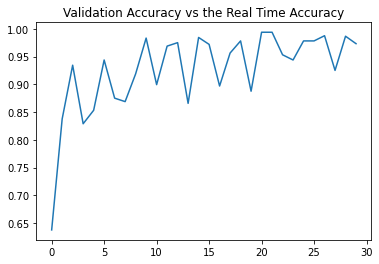

In [28]:
#Plotting the Accuracy
#TODO-Figure the val_accuracy missing
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c = "red")
plt.title("Validation Accuracy vs the Real Time Accuracy")
plt.show()

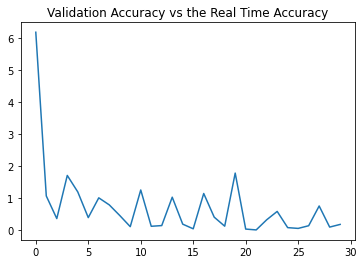

In [30]:
#Plotting the Loss
#TODO-Figure the val_loss missing
plt.plot(h['loss'])
plt.plot(h['val_loss'], c = "red")
plt.title("Validation Accuracy vs the Real Time Accuracy")
plt.show()

1/1 [==============================] - 0s 67ms/step


The MRI Image has a tumor


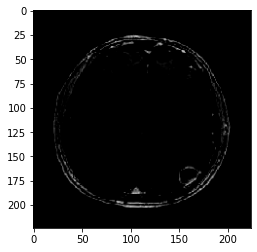

In [38]:
#Test the model with a random image
#The testing is done with the untouched original dataset -> commit
#TODO -> Fix the image prediction slice, its wrong as you can see below
from keras.preprocessing import image

path = '/content/BrH35_Modified/Healthy/no1051.jpg'
img = tf.keras.utils.load_img(path, target_size = (224, 224))

input_array = img_to_array(img)
input_array = preprocess_input(input_array)
input_array = np.array([input_array])
input_array.shape

#Which neuron has the highest probability
prediction = np.argmax(model.predict(input_array))
prediction
if prediction == 0:
  print("The MRI Image has a tumor")
else:
  print("The MRI does not have a tumor")

  #To display the image
plt.imshow(input_array[0])
plt.show()